# Solver

## Transition table

In [ ]:
from collections import deque
import pandas as pd
from IPython.display import display

# Define moves relative to the position of '9' (empty space)
# Each move corresponds to: up, right, down, left
directions = [-3, 1, 3, -1]  # Change in index for each move
move_names = ["Up", "Right", "Down", "Left"]

# Validate if a move is within bounds
def is_valid_move(index, direction):
    if direction == -3 and index < 3:  # Up
        return False
    if direction == 3 and index > 5:  # Down
        return False
    if direction == -1 and index % 3 == 0:  # Left
        return False
    if direction == 1 and index % 3 == 2:  # Right
        return False
    return True

# Swap two positions in a state
def swap(state, i, j):
    state = list(state)
    state[i], state[j] = state[j], state[i]
    return ''.join(state)

# Generate transitions for the 8-puzzle
def generate_transitions_8_puzzle(initial_state):
    visited = set()
    queue = deque([initial_state])
    transitions = {}

    while queue:
        current_state = queue.popleft()
        if current_state in visited:
            continue
        visited.add(current_state)

        empty_index = current_state.index('9')
        state_transitions = []

        for direction in directions:
            if is_valid_move(empty_index, direction):
                new_state = swap(current_state, empty_index, empty_index + direction)
                state_transitions.append(new_state)
                if new_state not in visited:
                    queue.append(new_state)
            else:
                state_transitions.append(None)  # Invalid move

        transitions[current_state] = state_transitions

    return transitions

# Initial state of the puzzle
initial_state = "123456789"

# Generate the transitions
transitions = generate_transitions_8_puzzle(initial_state)

# Convert to a DataFrame for better visualization
df_transitions = pd.DataFrame.from_dict(
    transitions,
    orient="index",
    columns=move_names
)
df_transitions.index.name = "State"

# Display the DataFrame using IPython
display(df_transitions)

,Up,Right,Down,Left
State,,,,
123456789,123459786,None,None,123456798
123459786,129453786,None,123456789,123495786
123456798,123496758,123456789,None,123456978
129453786,None,None,123459786,192453786
123495786,193425786,123459786,123485796,123945786
...,...,...,...,...
981254367,None,891254367,281954367,None
687251349,687259341,None,None,687251394
649857321,None,None,647859321,694857321


In [ ]:
transitions["123456789"]

['123459786', None, None, '123456798']

## Con entrenamiento CON ecuación de Bellman
&emsp;&emsp;**Q(s,a)=Q(s,a)+α(r+γa′max​Q(s′,a′)−Q(s,a))**

<br>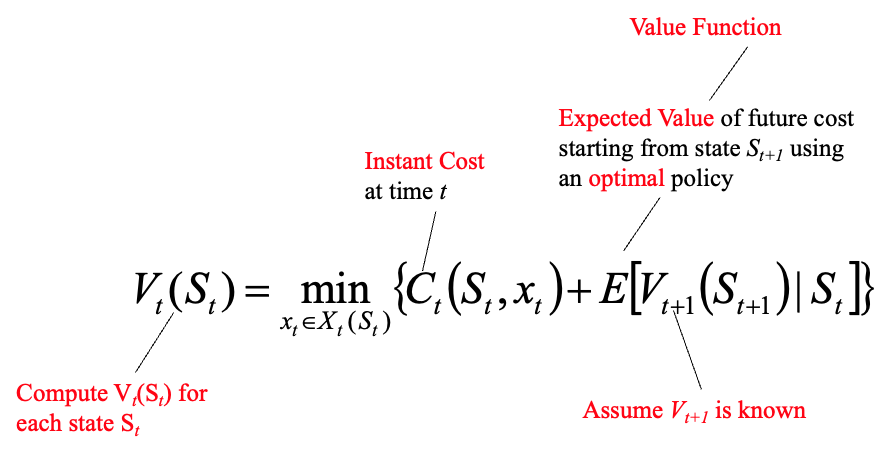

In [111]:
import numpy as np
import random
from collections import deque
import pandas as pd
from IPython.display import display
import time

# Define moves relative to the position of '9' (empty space)
# Each move corresponds to: up, right, down, left
directions = [-3, 1, 3, -1]  # Change in index for each move
move_names = ["Up", "Right", "Down", "Left"]
# Ejecutar Q-Learning
initial_state = "493215786"  # Estado inicial
goal_state = "123456789"  # Estado objetivo

# Validate if a move is within bounds
def is_valid_move(index, direction):
    if direction == -3 and index < 3:  # Up
        return False
    if direction == 3 and index > 5:  # Down
        return False
    if direction == -1 and index % 3 == 0:  # Left
        return False
    if direction == 1 and index % 3 == 2:  # Right
        return False
    return True

# Swap two positions in a state
def swap(state, i, j):
    state = list(state)
    state[i], state[j] = state[j], state[i]
    return ''.join(state)

# Generate all possible states and transitions for the 8-puzzle
def generate_transitions_8_puzzle(initial_state):
    visited = set()
    queue = deque([initial_state])
    transitions = {}

    while queue:
        current_state = queue.popleft()
        if current_state in visited:
            continue
        visited.add(current_state)

        empty_index = current_state.index('9')
        state_transitions = []

        for direction in directions:
            if is_valid_move(empty_index, direction):
                new_state = swap(current_state, empty_index, empty_index + direction)
                state_transitions.append(new_state)
                if new_state not in visited:
                    queue.append(new_state)
            else:
                state_transitions.append(None)  # Invalid move

        transitions[current_state] = state_transitions

    return transitions

# Show state 3x3
def print_state(state):
    state_list = list(state)
    for i in range(0, 9, 3):
        print(f"{state_list[i]} {state_list[i+1]} {state_list[i+2]}")
    print("")

# Inicializamos parámetros del Q-learning
def q_learning_8_puzzle(initial_state, goal_state, transitions, alpha=0.05, gamma=0.8, epsilon=0.1, episodes=1000):

    states = list(transitions.keys())
    q_table = {state: [0 for _ in move_names] for state in states}  # Inicializamos la Q-table

    step_counts = []  # Para registrar el número de pasos por episodio

    for episode in range(episodes):
        current_state = initial_state
        step = 0
        while current_state != goal_state and step < 100:  # Limitamos pasos por episodio
            step += 1
            empty_index = current_state.index('9')

            # Selección de acción con epsilon-greedy
            if random.random() < epsilon:
                action = random.choice(range(len(move_names)))  # Exploramos
            else:
                action = np.argmax(q_table[current_state])  # Explotamos

            # Realizamos la acción
            new_state = transitions[current_state][action]
            if new_state is None:  # Movimiento inválido
                reward = -10  # Penalizamos los movimientos inválidos
                q_table[current_state][action] += alpha * (
                    reward - q_table[current_state][action]
                )
                continue

            # Asignamos recompensa
            reward = 100 if new_state == goal_state else -1

            # Actualizamos el Q-value (Bellman ecuation)
            # Obtiene el valor máximo de Q para el nuevo estado (max Q en el siguiente estado)
            # Si el nuevo estado ya está en la tabla Q, toma el valor máximo; de lo contrario, usa 0.
            max_future_q = max(q_table[new_state]) if new_state in q_table else 0

            # Actualiza el valor Q de la acción tomada en el estado actual
            # La actualización sigue la ecuación de Bellman:
            # Q(s, a) = Q(s, a) + α * [reward + γ * max_future_q - Q(s, a)]
            # Donde:
            # - Q(s, a) es el valor Q actual de la acción a en el estado s.
            # - α (alpha) es la tasa de aprendizaje, que determina cuánto de la nueva información
            #    influye en el valor actual.
            # - r es la recompensa obtenida por realizar la acción a en el estado s.
            # - γ (gamma) es el factor de descuento, que controla el peso de las recompensas futuras.
            # - max_future_q es el valor máximo de Q en el siguiente estado (s'), considerando
            #    todas las posibles acciones a' en ese estado.
            q_table[current_state][action] += alpha * (  # Tasa de aprendizaje (α)
                reward + gamma * max_future_q - q_table[current_state][action]  # Diferencia de la predicción (target - current Q)
            )



            current_state = new_state

            # Mostramos los pasos realizados en la iteración 1000
            if episode == 999:  # Iteración 1000 (índice 999)
                print(f"")
                print(f"paso {step}:")
                #print(f"Iteración 1000, paso {step}:")
                #print("Estado actual:")
                #print_state(current_state)  # Mostrar el estado en 3x3
                print(f"Acción tomada: {move_names[action]}")
                print(f"Nuevo estado:")
                print_state(new_state)  # Mostrar el nuevo estado en 3x3
                print(f"Recompensa: {reward}")
                print(f"Q-table actualizada: {q_table[current_state]}")

        step_counts.append(step)

        # Mostrar progreso cada 100 episodios
        if (episode + 1) % 100 == 0:  # Cada 100 episodios
            print(f"Episodio {episode+1}: Promedio de pasos hasta ahora = {np.mean(step_counts):.2f}")
        if episode == 900:
          print(f"")
          print(f"Estado Inicial:")
          print_state(initial_state)
    print(f"")
    print(f"Promedio de pasos por episodio: {np.mean(step_counts):.2f}")
    return q_table


# Generar todas las transiciones para el puzzle
transitions = generate_transitions_8_puzzle(initial_state)

# Comenzamos a cronometrar el proceso de entrenamiento
start_time = time.time()  # Registrar el tiempo de inicio

# Entrenar agente Q-Learning (1000 episodios)
q_table = q_learning_8_puzzle(initial_state, goal_state, transitions, alpha=0.05, gamma=0.8, epsilon=0.1, episodes=1000)

# Tiempo total de ejecución
end_time = time.time()
execution_time = end_time - start_time
print(f"Tiempo total de entrenamiento: {execution_time:.4f} segundos")

# Mostrar la Q-table como un DataFrame
q_df = pd.DataFrame.from_dict(q_table, orient="index", columns=move_names)
q_df.index.name = "Estado"
display(q_df)


Episodio 100: Promedio de pasos hasta ahora = 91.74
Episodio 200: Promedio de pasos hasta ahora = 84.57
Episodio 300: Promedio de pasos hasta ahora = 62.45
Episodio 400: Promedio de pasos hasta ahora = 49.76
Episodio 500: Promedio de pasos hasta ahora = 41.64
Episodio 600: Promedio de pasos hasta ahora = 36.07
Episodio 700: Promedio de pasos hasta ahora = 32.08
Episodio 800: Promedio de pasos hasta ahora = 29.09
Episodio 900: Promedio de pasos hasta ahora = 26.77

Estado Inicial:
4 9 3
2 1 5
7 8 6


paso 1:
Acción tomada: Down
Nuevo estado:
4 1 3
2 9 5
7 8 6

Recompensa: -1
Q-table actualizada: [12.063716473744567, 4.601248581844911, 3.230111891186996, 29.40639999998634]

paso 2:
Acción tomada: Left
Nuevo estado:
4 1 3
9 2 5
7 8 6

Recompensa: -1
Q-table actualizada: [38.007999999998084, 13.638970132851975, 4.592103445050398, -8.062885155414989]

paso 3:
Acción tomada: Up
Nuevo estado:
9 1 3
4 2 5
7 8 6

Recompensa: -1
Q-table actualizada: [-7.364799055342576, 48.759999999999636, 18.53

,Up,Right,Down,Left
Estado,,,,
493215786,-8.251754,1.701736,22.525120,2.392814
439215786,-3.365796,-2.262191,-1.861414,10.376541
413295786,12.063716,4.601249,3.230112,29.406400
943215786,-3.365796,11.035113,-1.877153,-2.262191
435219786,-1.397484,-3.016627,-1.392519,-1.398313
...,...,...,...,...
634512897,0.000000,0.000000,0.000000,0.000000
697812354,0.000000,0.000000,0.000000,0.000000
687319524,0.000000,0.000000,0.000000,0.000000


## Con entrenamiento (1.000.000) con la ecuación de Bellman

In [113]:
import numpy as np
import random
from collections import deque
import pandas as pd
from IPython.display import display
import time

# Define moves relative to the position of '9' (empty space)
# Each move corresponds to: up, right, down, left
directions = [-3, 1, 3, -1]  # Change in index for each move
move_names = ["Up", "Right", "Down", "Left"]
# Ejecutar Q-Learning
initial_state = "493215786"  # Estado inicial
goal_state = "123456789"  # Estado objetivo

# Validate if a move is within bounds
def is_valid_move(index, direction):
    if direction == -3 and index < 3:  # Up
        return False
    if direction == 3 and index > 5:  # Down
        return False
    if direction == -1 and index % 3 == 0:  # Left
        return False
    if direction == 1 and index % 3 == 2:  # Right
        return False
    return True

# Swap two positions in a state
def swap(state, i, j):
    state = list(state)
    state[i], state[j] = state[j], state[i]
    return ''.join(state)

# Generate all possible states and transitions for the 8-puzzle
def generate_transitions_8_puzzle(initial_state):
    visited = set()
    queue = deque([initial_state])
    transitions = {}

    while queue:
        current_state = queue.popleft()
        if current_state in visited:
            continue
        visited.add(current_state)

        empty_index = current_state.index('9')
        state_transitions = []

        for direction in directions:
            if is_valid_move(empty_index, direction):
                new_state = swap(current_state, empty_index, empty_index + direction)
                state_transitions.append(new_state)
                if new_state not in visited:
                    queue.append(new_state)
            else:
                state_transitions.append(None)  # Invalid move

        transitions[current_state] = state_transitions

    return transitions

# Show state 3x3
def print_state(state):
    state_list = list(state)
    for i in range(0, 9, 3):
        print(f"{state_list[i]} {state_list[i+1]} {state_list[i+2]}")
    print("")

# Inicializamos parámetros del Q-learning
def q_learning_8_puzzle(initial_state, goal_state, transitions, alpha=0.05, gamma=0.8, epsilon=0.1, episodes=1000000):

    states = list(transitions.keys())
    q_table = {state: [0 for _ in move_names] for state in states}  # Inicializamos la Q-table

    step_counts = []  # Para registrar el número de pasos por episodio

    for episode in range(episodes):
        current_state = initial_state
        step = 0
        while current_state != goal_state and step < 100:  # Limitamos pasos por episodio
            step += 1
            empty_index = current_state.index('9')

            # Selección de acción con epsilon-greedy
            if random.random() < epsilon:
                action = random.choice(range(len(move_names)))  # Exploramos
            else:
                action = np.argmax(q_table[current_state])  # Explotamos

            # Realizamos la acción
            new_state = transitions[current_state][action]
            if new_state is None:  # Movimiento inválido
                reward = -10  # Penalizamos los movimientos inválidos
                q_table[current_state][action] += alpha * (
                    reward - q_table[current_state][action]
                )
                continue

            # Asignamos recompensa
            reward = 100 if new_state == goal_state else -1

            # Actualizamos el Q-value (Bellman ecuation)
            # Obtiene el valor máximo de Q para el nuevo estado (max Q en el siguiente estado)
            # Si el nuevo estado ya está en la tabla Q, toma el valor máximo; de lo contrario, usa 0.
            max_future_q = max(q_table[new_state]) if new_state in q_table else 0

            # Actualiza el valor Q de la acción tomada en el estado actual
            # La actualización sigue la ecuación de Bellman:
            # Q(s, a) = Q(s, a) + α * [reward + γ * max_future_q - Q(s, a)]
            # Donde:
            # - Q(s, a) es el valor Q actual de la acción a en el estado s.
            # - α (alpha) es la tasa de aprendizaje, que determina cuánto de la nueva información
            #    influye en el valor actual.
            # - r es la recompensa obtenida por realizar la acción a en el estado s.
            # - γ (gamma) es el factor de descuento, que controla el peso de las recompensas futuras.
            # - max_future_q es el valor máximo de Q en el siguiente estado (s'), considerando
            #    todas las posibles acciones a' en ese estado.
            q_table[current_state][action] += alpha * (  # Tasa de aprendizaje (α)
                reward + gamma * max_future_q - q_table[current_state][action]  # Diferencia de la predicción (target - current Q)
            )

            current_state = new_state

            # Mostramos los pasos realizados en la iteración 1000
            if episode == 999999:  # Iteración 1000 (índice 999)
                print(f"")
                print(f"paso {step}:")
                #print(f"Iteración 1000, paso {step}:")
                #print("Estado actual:")
                #print_state(current_state)  # Mostrar el estado en 3x3
                print(f"Acción tomada: {move_names[action]}")
                print(f"Nuevo estado:")
                print_state(new_state)  # Mostrar el nuevo estado en 3x3
                print(f"Recompensa: {reward}")
                print(f"Q-table actualizada: {q_table[current_state]}")

        step_counts.append(step)

        # Mostrar progreso cada 100 episodios
        if (episode + 1) % 100000 == 0:  # Cada 100 episodios
            print(f"Episodio {episode+1}: Promedio de pasos hasta ahora = {np.mean(step_counts):.2f}")
        if episode == 900000:
          print(f"")
          print(f"Estado Inicial:")
          print_state(initial_state)
    print(f"")
    print(f"Promedio de pasos por episodio: {np.mean(step_counts):.2f}")
    return q_table


# Generar todas las transiciones para el puzzle
transitions = generate_transitions_8_puzzle(initial_state)

# Comenzamos a cronometrar el proceso de entrenamiento
start_time = time.time()  # Registrar el tiempo de inicio

# Entrenar agente Q-Learning (1000 episodios)
q_table = q_learning_8_puzzle(initial_state, goal_state, transitions, alpha=0.05, gamma=0.8, epsilon=0.1, episodes=1000000)

# Tiempo total de ejecución
end_time = time.time()
execution_time = end_time - start_time
print(f"Tiempo total de entrenamiento: {execution_time:.4f} segundos")

# Mostrar la Q-table como un DataFrame
q_df = pd.DataFrame.from_dict(q_table, orient="index", columns=move_names)
q_df.index.name = "Estado"
display(q_df)


Episodio 100000: Promedio de pasos hasta ahora = 8.23
Episodio 200000: Promedio de pasos hasta ahora = 8.13
Episodio 300000: Promedio de pasos hasta ahora = 8.10
Episodio 400000: Promedio de pasos hasta ahora = 8.08
Episodio 500000: Promedio de pasos hasta ahora = 8.07
Episodio 600000: Promedio de pasos hasta ahora = 8.07
Episodio 700000: Promedio de pasos hasta ahora = 8.06
Episodio 800000: Promedio de pasos hasta ahora = 8.06
Episodio 900000: Promedio de pasos hasta ahora = 8.05

Estado Inicial:
4 9 3
2 1 5
7 8 6


paso 1:
Acción tomada: Down
Nuevo estado:
4 1 3
2 9 5
7 8 6

Recompensa: -1
Q-table actualizada: [17.020095999999768, 17.020095999999768, 17.020095999999768, 29.406399999999735]

paso 2:
Acción tomada: Left
Nuevo estado:
4 1 3
9 2 5
7 8 6

Recompensa: -1
Q-table actualizada: [38.00799999999971, 22.525119999999752, 22.525119999999752, -9.999999999999982]

paso 3:
Acción tomada: Up
Nuevo estado:
9 1 3
4 2 5
7 8 6

Recompensa: -1
Q-table actualizada: [-9.999999999999982, 48.7

,Up,Right,Down,Left
Estado,,,,
493215786,-10.000000,12.616077,22.525120,12.616077
439215786,-10.000000,-10.000000,9.092861,17.020096
413295786,17.020096,17.020096,17.020096,29.406400
943215786,-10.000000,17.020096,9.092861,-10.000000
435219786,12.616077,-7.960932,-0.816304,1.028875
...,...,...,...,...
634512897,0.000000,0.000000,0.000000,0.000000
697812354,0.000000,0.000000,0.000000,0.000000
687319524,0.000000,0.000000,0.000000,0.000000


https://colab.research.google.com/drive/1qNX-QLXWT2aS3ulucFkaPoXn-LbgFc_j?usp=sharing#scrollTo=R7tsP5TcCo2T